In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [55]:
def test_sample(double_well, network, temperature=1.0, nsample=100000, plot=True):
    if nsample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=nsample)
    else:
        sample_x = []
        for i in range(int(nsample/100000)):
            _, sample_x_, _, _, _ = network.sample(temperature=temperature, nsample=nsample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100);
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature);
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

In [7]:
# reweighting
def test_sample_rew(network, temperature=1.0, plot=True):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], bins=100, range=(-2.5, 2.5), nbootstrap=100, log_weights=log_w)
    plt.figure(figsize=(4, 4))
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    if plot:
        double_well.plot_dimer_energy()
        plt.errorbar(bin_means, Emean, Estd, linewidth=2, color='green')
    # variance
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [8]:
def hist_weights(network):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bins = np.linspace(-2.5, 2.5, 100)
    bin_means = 0.5 * (bins[:-1] + bins[1:])
    sample_x_index = np.digitize(sample_x[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_w)):
        whist[sample_x_index[i]] += np.exp(log_w[i])
    return bin_means, whist[1:-1]

In [9]:
def test_mcmc(network, nsample):
    fig, axes = plt.subplots(2, 1, figsize=(7, 7))
    # test sampling
    gp_mcmc = GaussianPriorMCMC(network)#, std_z=[0.7, 1.0])
    Z, X, E, J = gp_mcmc.run(nsample)
    print('Transitions:', count_transitions(X[:, 0], -1, 1))
    axes[0].plot(X[:min(10000, nsample), 0])
    # plot PMF
    h, b = np.histogram(X[:, 0], bins=100)
    b = 0.5 * (b[:-1] + b[1:])
    F = -np.log(h)
    Edimer = double_well.plot_dimer_energy(axes[1])
    axes[1].plot(b, F-F.min()+Edimer.min())

In [10]:
def plot_transformation_field_2d(transformer, bounds, ngrid=20, ):
    # build grid
    x_coarse_grid = np.linspace(bounds[0], bounds[1], num=ngrid)
    y_coarse_grid = np.linspace(bounds[2], bounds[3], num=ngrid)
    grid = []
    for i in range(len(x_coarse_grid)):
        for j in range(len(y_coarse_grid)):
            grid.append([x_coarse_grid[i], y_coarse_grid[j]])
    grid = np.array(grid)

    # compute transformation field
    grid_pred = transformer.predict(grid)

    # show field
    plt.figure(figsize=(5, 5))
    plt.quiver(grid[:, 0], grid[:, 1], grid_pred[:, 0], grid_pred[:, 1], units='width')

In [11]:
def getx(x):
    return x[:, 0]

Plotting function, sort of generic
-----

In [12]:
def plot_network(network, weight_cutoff=1e-2):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3.5))
    plt.subplots_adjust(wspace=0.25)
    # Plot X distribution
    axis = axes[0]
    axis.plot(traj_left[:, 0], traj_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(x_ts[:, 0], x_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(traj_right[:, 0], traj_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    axis.set_xlabel('$x_1$')
    axis.set_xlim(-3, 3)
    axis.set_ylabel('$x_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    # Plot Z distribution
    axis = axes[1]
    z_left = network.transform_xz(traj_left)
    z_ts = network.transform_xz(x_ts)
    z_right = network.transform_xz(traj_right)
    axis.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(z_ts[:, 0], z_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
    axis.add_artist(circle)
    axis.set_xlabel('$z_1$')
    axis.set_xlim(-4, 4)
    axis.set_ylabel('$z_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    # Plot proposal distribution
    X1, Y1 = test_sample(network, temperature=1.0, plot=False);
    _, W1 = hist_weights(network)
    axis = axes[2]
    Ex, E = double_well.plot_dimer_energy(axis=axis, temperature=1.0)
    Y1 = Y1 - Y1.min() + E.min()
    Inan = np.where(W1 < weight_cutoff)
    Y1[Inan] = np.nan
    #Y2 = Y2 - Y2.min() + E.min()
    #axis.plot(X2, Y2, color='#FF6600', linewidth=2, label='ML+KL+RC')
    axis.plot(X1, Y1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([]);
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('Energy / kT')
    #plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
    # Plot reweighted distribution
    RX1, RY1, DR1 = test_sample_rew(network, temperature=1.0, plot=False);
    axis = axes[3]
    Ex, E = double_well.plot_dimer_energy(axis=axis, temperature=1.0)
    RY1 = RY1 - RY1[np.isfinite(RY1)].min() + E.min()
    RY1[Inan] = np.nan
    #RY1[RY1 > -4] = np.nan
    #RY2 = RY2 - RY2[np.isfinite(RY2)].min() + E.min()
    #axis.errorbar(RX2, RY2, DR2, color='#FF6600', linewidth=2, label='ML+KL+RC')
    axis.errorbar(RX1, RY1, DR1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4]);
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('')
    return fig, axes

In [13]:
def low_energy_fraction(energies, Emax):
    low_energy_count = [np.count_nonzero(E<Emax) for E in energies]
    sizes = [E.size for E in energies]
    low_energy_fraction = np.array(low_energy_count) / sizes
    return low_energy_fraction

In [14]:
def plot_convergence(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # low energy fractions
    enerx = hist_ML[2] + hist_KL[3]
    enerz = hist_ML[3] + hist_KL[4]
    lef_x = low_energy_fraction(enerx, enerx_cut)
    lef_z = low_energy_fraction(enerz, enerz_cut)
    axes[2].plot(lef_x, color='black', label='x')
    axes[2].plot(lef_z, color='blue', label='z')
    axes[2].set_xlim(0, niter + 1)
    axes[2].set_ylim(0, 1.05)
    axes[2].axvline(x=200, color='red', linestyle='--', linewidth=3)
    axes[2].set_ylabel('Training iterations')
    axes[2].set_ylabel('Low energy fraction')
    axes[2].legend()
    return fig, axes

Double well
---

In [15]:
paper_dir = '/Users/noe/data/open_projects/boltzmann_generators/coarsegraining_KL/'

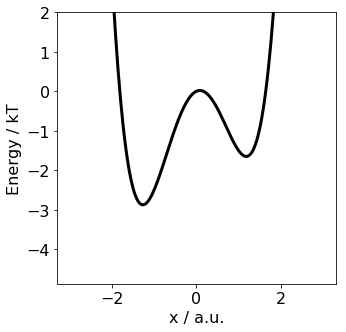

In [17]:
params = DoubleWell.params_default.copy()
params['dim'] = 2
params['a1'] = 0.5
params['a2'] = 3
double_well = DoubleWell(params=params)
plt.figure(figsize=(5,5))
double_well.plot_dimer_energy();
#plt.savefig(paper_dir + 'figs/double_well/potential.pdf', bbox_inches='tight')

In [91]:
def plot_potential(cbar=True, orientation='vertical', figsize=(4, 5.5)):
    # 2D potential
    xgrid = np.linspace(-2, 2, 100)
    ygrid = np.linspace(-5, 5, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    E = double_well.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=4)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.5, 7.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            #cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
    plt.xticks([-2, 0, 2])
    plt.yticks([-4, 0, 4])
    plt.xlabel('$x_1$', labelpad=0)
    plt.ylabel('$x_2$', labelpad=-10)

(-5, 5)

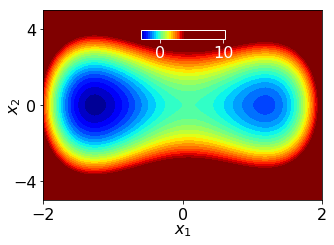

In [93]:
plot_potential(orientation='horizontal', figsize=(5, 5))
plt.savefig(paper_dir + 'figs/double_well_true2d.pdf', bbox_inches='tight', transparent=True)
plt.ylim(-5, 5)

In [23]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [57]:
nsteps = 100000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

Text(0.5,0,'Probability')

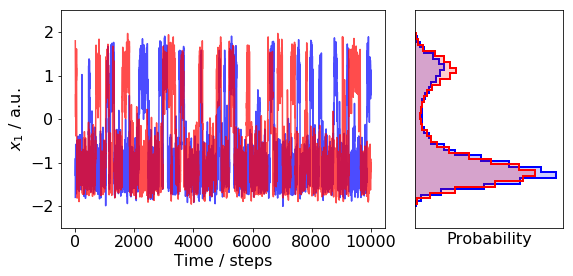

In [58]:
plt.figure(figsize=(9, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(traj_left[:, 0], color='blue', alpha=0.7)
ax1.plot(traj_right[:, 0], color='red', alpha=0.7)
#ax1.set_xlim(0, 1000)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('$x_1$ / a.u.')
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Probability')
#plt.savefig(paper_dir + 'figs/double_well/prior_trajs.pdf', bbox_inches='tight')

In [59]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

In [60]:
# prepare transition state
x_ts = np.vstack([np.zeros(1000), (1.0/double_well.params['k']) * np.random.randn(1000)]).T

Coarse-graining
------
Since we need at least 2 variables in the BG, we take the slow coordinate and add an artifical harmonic variable. For the double well this results in the same behavior as the original trajectory because the second variable is harmonic.

In [61]:
x_CG = getx(x)
xval_CG = getx(xval)
x_CG_aug = np.vstack([x_CG, np.random.randn(x_CG.size)]).T
xval_CG_aug = np.vstack([xval_CG, np.random.randn(xval_CG.size)]).T

Training
-------

In [62]:
epochsZ = 3000
batchsize_ML = 128
temperature = 1.0
explore = 1.0

In [63]:
bg = invnet(double_well.dim, 'RRRRR', double_well, nl_layers=4, nl_hidden=[100, 10, 100], 
            nl_activation='relu', nl_activation_scale='tanh')

<RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [64]:
hist = bg.train_ML(x_CG_aug, xval=xval_CG_aug, lr=0.00025, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, 
                   verbose=0, return_test_energies=True)

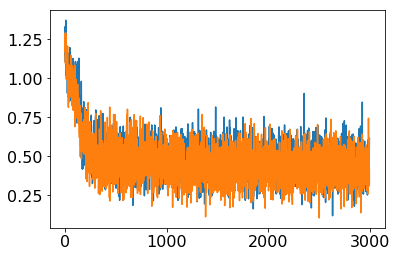

In [65]:
plt.plot(hist[0])
plt.plot(hist[1])

TypeError: test_sample() missing 1 required positional argument: 'network'

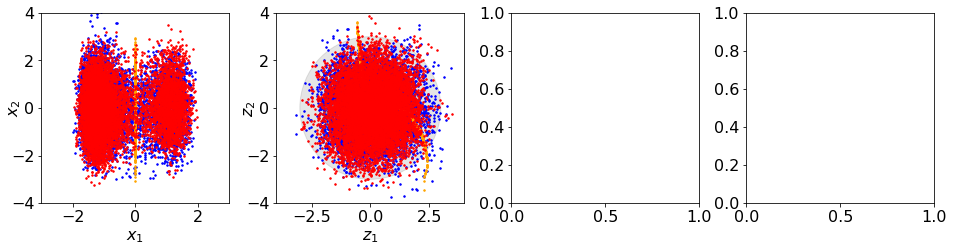

In [66]:
fig, axes = plot_network(bg, weight_cutoff=1e-2);
#fig.savefig(paper_dir + 'figs/double_well/network_NICER_KLML.pdf', bbox_inches='tight')

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


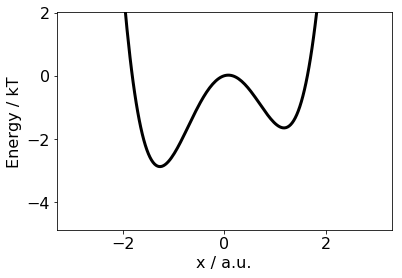

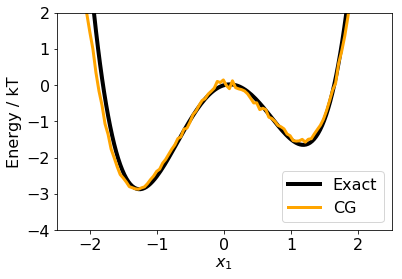

In [82]:
xgrid, egrid = double_well.plot_dimer_energy()
plt.figure(figsize=(6, 4))
plt.plot(xgrid, egrid, linewidth=4, color='black', label='Exact')
_, sample_x, _, _, _ = bg.sample()
hist, bin_edges = np.histogram(sample_x[:, 0], bins=100, density=True);
bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_values, -np.log(hist)-2.9, color='orange', linewidth=3, label='CG')
#test_sample(double_well, bg)
plt.xlim(-2.5, 2.5)
plt.ylim(-4, 2)
plt.xlabel('$x_1$')
plt.ylabel('Energy / kT')
plt.legend()
plt.savefig(paper_dir + 'figs/double_well_1d.pdf', bbox_inches='tight', transparent=True)